In [12]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
import torch
import torch.nn.functional as F
import itertools
from scipy.stats import pointbiserialr
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score
from scipy.stats import spearmanr
from scipy.stats import entropy

from tqdm.auto import tqdm
import re

pd.set_option('display.max_columns', 500)

Features epigenomiche con FFNN e sequenze raw con CNN o LSTM.
Task:
- Identificazione di enhancers e promoters
- 2 directories: enhancers and promoters: quali sono attivi e inattivi nelle regioni 

tasks:
- Active PROMOTERS vs inactive PROMOTERS
- Active ENHANCERS vs inactive ENHANCERS

- Active ENHANCERS vs active PROMOTERS
- Inactive ENHANCERS vs inactive PROMOTERS
- Active ENHANCERS + active PROMOTERS vs inactive

Enhancers.bed indica l’etichettatura
Per ogni posizione 1 se la regione è attiva, 0 se è inattiva.

1 dataset per ogni regione regolatori da trattare indipendentemente. 7 diversi dataset. 
Usa cdv e pacchetto di luca

One hot encoding delle sequence raw. 


An immortalised cell line is a population of cells from a multicellular organism which would normally not proliferate indefinitely but, due to mutation, have evaded normal cellular senescence and instead can keep undergoing division. The cells can therefore be grown for prolonged periods in vitro. The mutations required for immortality can occur naturally or be intentionally induced for experimental purposes. Immortal cell lines are a very important tool for research into the biochemistry and cell biology of multicellular organisms. Immortalised cell lines have also found uses in biotechnology.

1. FLAT FEATURES
- A549: they are adenocarcinomic human alveolar basal epithelial cells, and constitute a cell line that was first developed in 1972 by D. J. Giard, et al. through the removal and culturing of cancerous lung tissue in the explanted tumor of a 58-year-old caucasian male. The cells are used as models for the study of lung cancer 
- GM12878: B-Lymphocyte with Epstein-Barr Virus. it is a lymphoblastoid cell line produced from the blood of a female donor with northern and western European ancestry by EBV transformation. A lymphoblast is a modified naive lymphocyte with altered cell morphology. It occurs when the lymphocyte is activated by an antigen (from antigen-presenting cells) and increased in volume by nucleus and cytoplasm growth as well as new mRNA and protein synthesis.Lymphoblasts can also refer to immature cells which typically differentiate to form mature lymphocytes. Normally lymphoblasts are found in the bone marrow, but in acute lymphoblastic leukemia (ALL), lymphoblasts proliferate uncontrollably and are found in large numbers in the peripheral blood.
- H1: human embryonic stem cell line, usually called H1-hESC and on occasion just H1
- HEK293: Human embryonic kidney 293 cells, also often referred to as HEK 293, HEK-293, 293 cells, or less precisely as HEK cells, are a specific cell line originally derived from human embryonic kidney cells grown in tissue culture taken from a female fetus.
- HepG2:  is a human liver cancer cell line. Hep G2 is an immortal cell line which was derived in 1975 from the liver tissue of a 15-year-old Caucasian male from Argentina with a well-differentiated hepatocellular carcinoma.
- K562: they were the first human immortalised myelogenous leukemia cell line to be established. K562 cells are of the erythroleukemia type, and the cell line is derived from a 53-year-old female chronic myelogenous leukemia patient in blast crisis
- MCF-7: is a breast cancer cell line isolated in 1970 from a 69-year-old White woman.

2. SEQUENCE DATA
- .fa file: it contains the effective genomic sequence

3. TARGET
- .bed file: it tells us wether a certain genomic region of each cell line contains or not an enhancer or a promoter

In [ ]:
from BIOINF_utils.dataload import Load_Create_Task

In [85]:
data = Load_Create_Task()
data.load(verbose=True)


enhancers files:
['A549', 'GM12878', 'H1', 'HEK293', 'HEPG2', 'K562', 'MCF7', 'bed', 'fa']

bed has shape: (63285, 11)
MCF7 has shape: (63285, 121)
GM12878 has shape: (63285, 156)
A549 has shape: (63285, 52)
H1 has shape: (63285, 62)
K562 has shape: (63285, 433)
fa has shape: (63285, 4)
HEPG2 has shape: (63285, 566)
HEK293 has shape: (63285, 200)

promoters files:
['A549', 'GM12878', 'H1', 'HEK293', 'HEPG2', 'K562', 'MCF7', 'bed', 'fa']

MCF7 has shape: (99881, 121)
fa has shape: (99881, 4)
GM12878 has shape: (99881, 156)
A549 has shape: (99881, 52)
H1 has shape: (99881, 62)
K562 has shape: (99881, 433)
HEPG2 has shape: (99881, 566)
bed has shape: (99881, 11)
HEK293 has shape: (99881, 200)


In [68]:
data_dict, labels_dict = data.get_task('inactive_E_vs_inactive_P')

- DNA strand orientation (positive ["+"] or negative ["-"] or "." if no strand)

- csv files: Per ogni linea cellulare, in corrispondenza delle stesse coordinate ci sono linee epigenomiche ex: gm12878.csv. Per ogni area c’è una serie di valori (matrice) che rappresentano features epigenomiche. Dicono in cosa è implicata la regione. H3k.. sono modificazioni istoniche <br> h3k4n1: stato della cromatina. Indica se è aperta o meno, quindi se è alta, l’area è aperta e quindi è facile che sia trascritta e vice versa.

- fasta file: regioni di 256 bp centrata

Enhancers.fasta 
Head enhancers.fa

- prima linea: cromosoma e coordinate di inizio e fine dell’area del dna

seconda linea: sequenza di basi azotate 

## CHECK MISSING VALUES

In [167]:
data_dict, labels_dict = data.get_task('active_EP_vs_inactive_rest')

data_prep = Data_Preparation(data_dict, labels_dict)
data_prep.scale_data_genfeatures()

In [168]:
data_dict = data_prep.data_dict

In [173]:
for key in data_dict.keys():
    if key !='fa':
        for col in data_dict[key].columns:
            if data_dict[key][col].isna().sum():
                print('dataset: {}, column: {}, nan: {}'.format(key,col, data_dict[key][col].isna().sum()))
    else:
        if data_dict[key].isna().sum():
                print('dataset: {}, nan: {}'.format(key, data_dict[key].isna().sum()))

dataset: MCF7, column: ATAC-seq, nan: 91
dataset: MCF7, column: DNase-seq, nan: 91
dataset: GM12878, column: NRF1, nan: 1
dataset: GM12878, column: STAT5A, nan: 1
dataset: GM12878, column: NFIC, nan: 1
dataset: GM12878, column: KAT2A, nan: 1
dataset: GM12878, column: BATF, nan: 1
dataset: GM12878, column: NFYA, nan: 1
dataset: GM12878, column: POLR2AphosphoS2, nan: 1
dataset: GM12878, column: MXI1, nan: 1
dataset: GM12878, column: STAT3, nan: 1
dataset: GM12878, column: REST, nan: 1
dataset: GM12878, column: ATAC-seq, nan: 91
dataset: GM12878, column: GABPA, nan: 1
dataset: GM12878, column: NR2C2, nan: 1
dataset: GM12878, column: whole-genome shotgun bisulfite sequencing, nan: 254
dataset: GM12878, column: RUNX3, nan: 1
dataset: GM12878, column: H4K20me1, nan: 1
dataset: GM12878, column: USF1, nan: 1
dataset: GM12878, column: CUX1, nan: 1
dataset: GM12878, column: USF2, nan: 1
dataset: GM12878, column: TBP, nan: 1
dataset: GM12878, column: MAX, nan: 1
dataset: GM12878, column: MEF2A, n

In [174]:
data_dict_fa = data_dict['fa'].apply(lambda x: [i for i in x.lower()] )

In [175]:
for row in data_dict_fa.index:
    if 'n' in data_dict_fa[row]:
        print('row n: {}, nan: {}'.format(row, data_dict_fa[row].count('n')))

row n: 93539, nan: 1
row n: 93540, nan: 1


We can perform data imputation since there are few missing values for each column compared to the total number of observations (at most $343$ over $163.166$) and 2 missing nucleotides in the sequence files.

## PREPROCESSING FUNCTION

In [ ]:
from BIOINF_utils.dataload import Data_Preparation
from BIOINF_utils.dataload import Dataset_Wrap
from BIOINF_utils.dataload import BalancePos_BatchSampler
from BIOINF_utils.dataload import Build_DataLoader_Pipeline

In [ ]:
data = Data_Preparation(data_dict, labels_dict)
data.scale_data_genfeatures()

In [133]:
data_dict, labels_dict = data.get_task('active_E_vs_active_P')

In [134]:
pipe_data_load = Build_DataLoader_Pipeline(data_dict, labels_dict, path_name='.pickle', verbose=False)

Data transformation Done!

Data Preprocessing Done!


In [135]:
loader_train, loader_test = pipe_data_load.return_data(cell_line='H1', 
                    hyper_tuning=True, 
                    sequence=False)

## LABEL IMBALANCE

In [153]:
data_dict, labels_dict = data.get_task('active_E_vs_active_P')

In [158]:
from matplotlib import pyplot as plt
import pylab as plt

def plot_label_ratio(labels_dict, title=None):
    fig, axes = plt.subplots(2,4, figsize=[20,10])

    row=0
    col=0

    fig.suptitle(title, fontsize=20)
    
    cell_lines = list(labels_dict.keys())
    
    if 'index_fa' in cell_lines:
        cell_lines.remove('index_fa')
        
    for cell,ax in zip(cell_lines, axes.flatten()):
        x = np.unique(labels_dict[cell], return_counts=True)[1]
        ax.pie(x=x, autopct="%.1f%%", explode=[0.03]*2,  labels=['0','1'], pctdistance=0.5, 
               colors=['#A9A9A9','#32CD32'],textprops={'fontsize': 15})
        ax.set_title(str(cell), fontsize=16)
        ax

        col+=1
        if col==4:
            row+=1
            col=0
            
    fig.delaxes(axes[row][col])

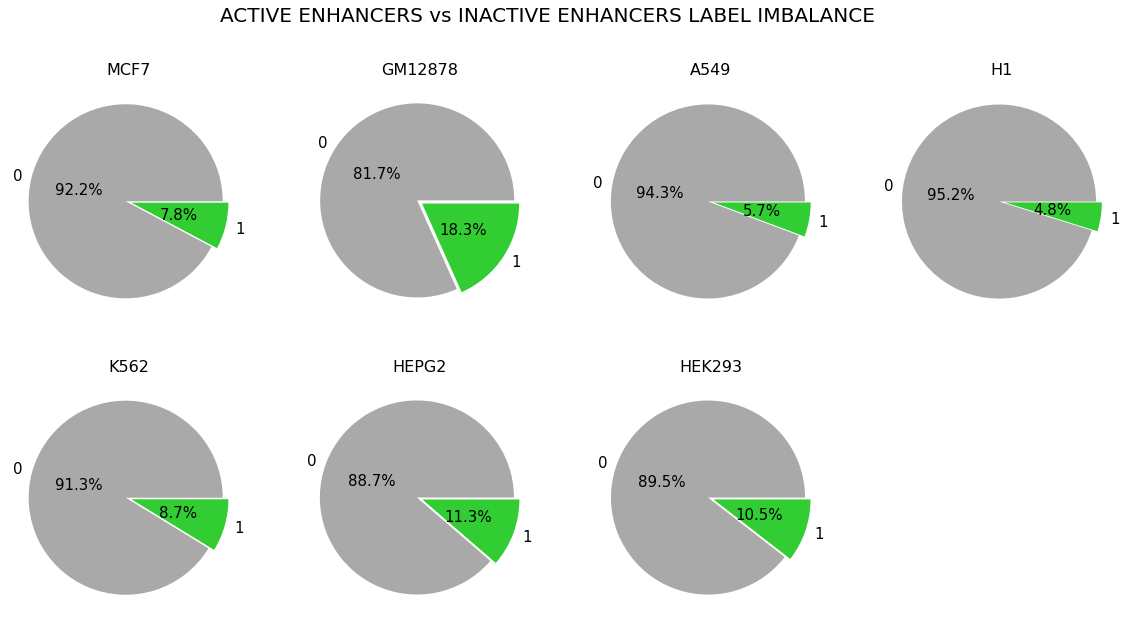

In [150]:
plot_label_ratio(labels_dict, 'ACTIVE ENHANCERS vs INACTIVE ENHANCERS LABEL IMBALANCE')

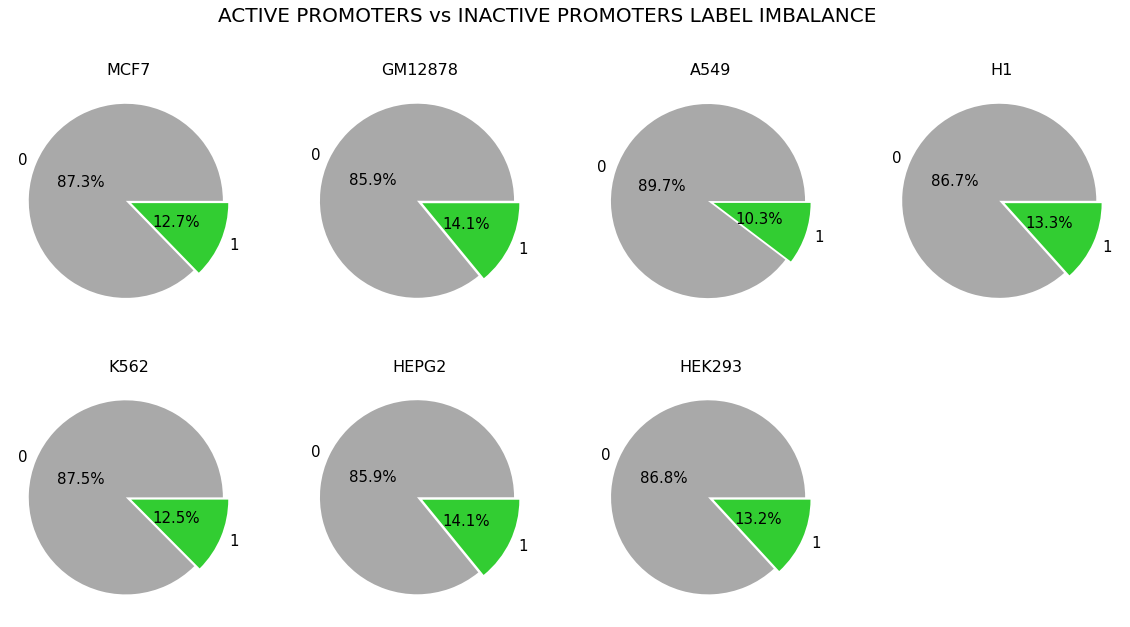

In [152]:
plot_label_ratio(labels_dict, 'ACTIVE PROMOTERS vs INACTIVE PROMOTERS LABEL IMBALANCE')

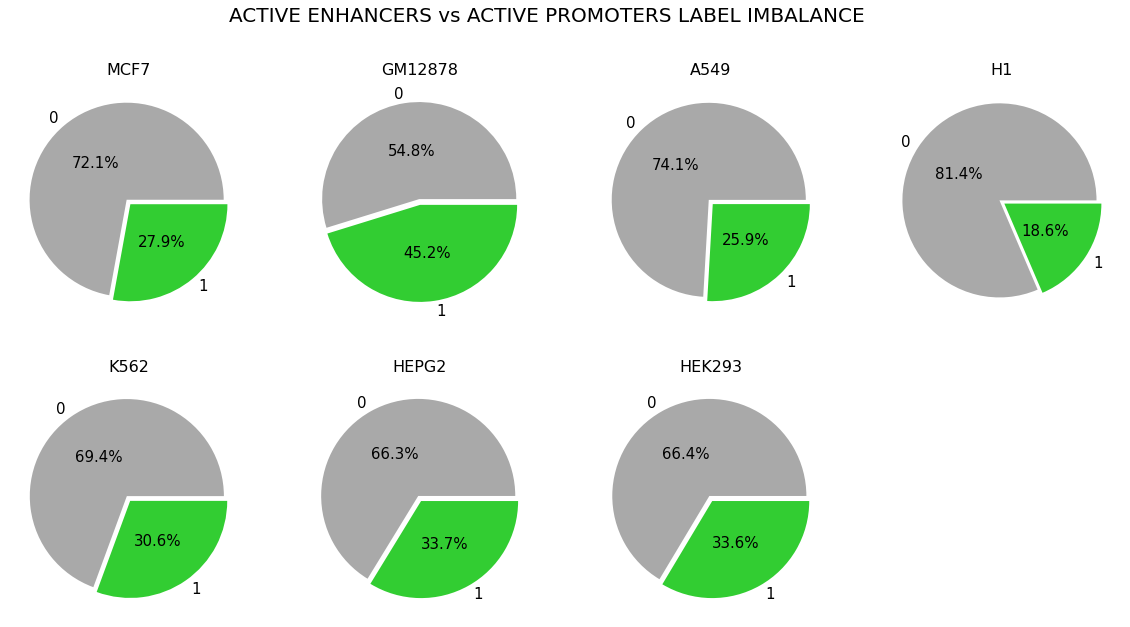

In [159]:
plot_label_ratio(labels_dict, 'ACTIVE ENHANCERS vs ACTIVE PROMOTERS LABEL IMBALANCE')

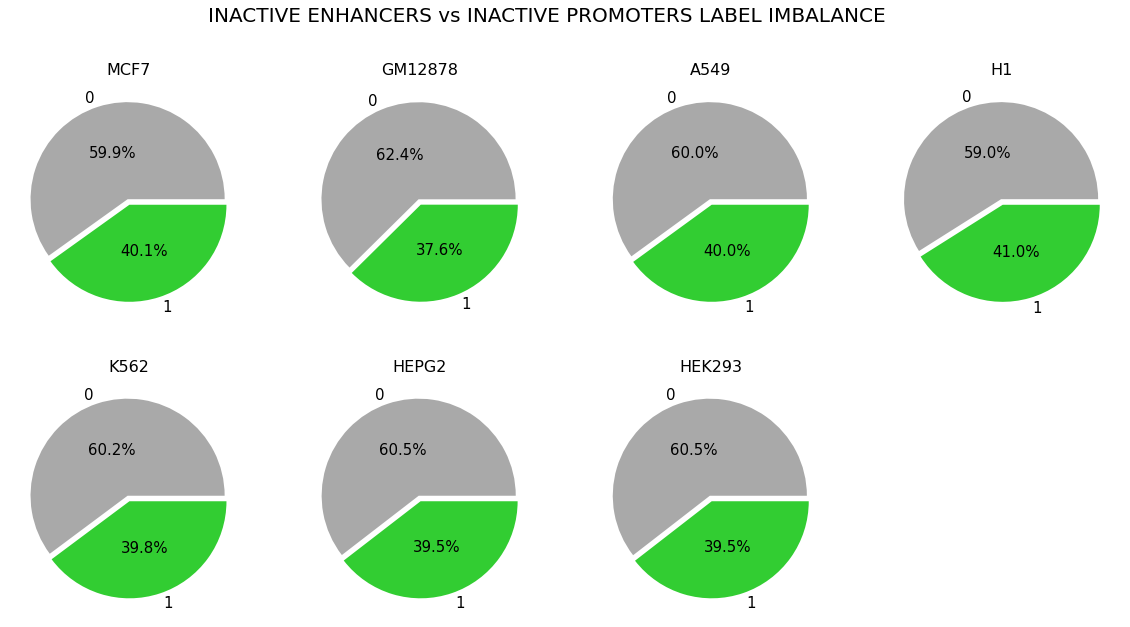

In [161]:
plot_label_ratio(labels_dict, 'INACTIVE ENHANCERS vs INACTIVE PROMOTERS LABEL IMBALANCE')

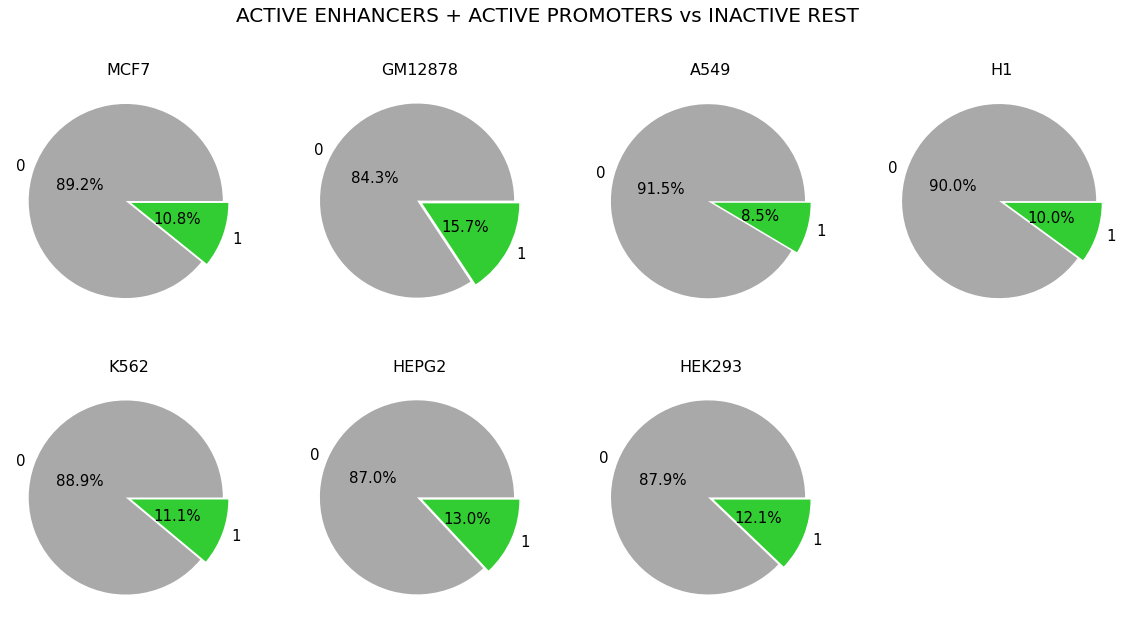

In [164]:
plot_label_ratio(labels_dict, 'ACTIVE ENHANCERS + ACTIVE PROMOTERS vs INACTIVE REST')

---

In [763]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(k_neighbors=3)

for data, label in loader_train:
    data,label = oversample.fit_resample(data,label.ravel())
    data = torch.tensor(data)
    label = torch.tensor(label)
    break

In [174]:
from imblearn.over_sampling import SMOTEN
oversample = SMOTEN(k_neighbors=3)
onehot_encoder = OneHotEncoder(sparse=False).fit(np.array([0,1,2,4]).reshape(-1, 1)) 

for data, label in loader_train:
    
    # n_batches, n.elements per obs
    data = data.reshape(data.shape[0], -1)
    data,label = oversample.fit_resample(data,label.ravel())
    
    data_ = []
    for x in data:
        data_.append(onehot_encoder.transform(np.array(x).reshape(-1, 1)))
    
    # final size: n_batches, n_channels, size of matrix (256*4)
    data = torch.tensor(data_).reshape(-1,1,256,4)
    
    
    break

---